In [1]:
import pandas as pd
# Load fear & greed index
fg_df = pd.read_csv('fear_greed_index.csv')
print("Fear & Greed Data Loaded")
display(fg_df.head())  # Show first rows

# Load historical trading data
trades_df = pd.read_csv('historical_data.csv')
print("Historical Trading Data Loaded")
display(trades_df.head())


Fear & Greed Data Loaded


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Historical Trading Data Loaded


,Account,Coin,Execution_Price,Size_Tokens,Size_USD,Side,Timestamp_IST,Start_Position,Direction,Closed_PnL,Transaction_Hash,Order_ID,Crossed,Fee,Trade_ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [2]:
# Standardize column names
trades_df.columns = trades_df.columns.str.strip().str.replace(' ', '_')

# Ensure timestamp is a string before splitting
trades_df['Timestamp_IST'] = trades_df['Timestamp_IST'].astype(str)

# Split timestamp into separate Date and Time columns
trades_df[['Date1', 'Time']] = trades_df['Timestamp_IST'].str.split(' ', expand=True)

# Convert dates to datetime format
trades_df['Date1'] = pd.to_datetime(trades_df['Date1'], errors='coerce')
fg_df['date'] = pd.to_datetime(fg_df['date'], errors='coerce')


In [3]:
# Extract date only for merging
trades_df['date_only'] = trades_df['Date1'].dt.date
fg_df['date_only'] = fg_df['date'].dt.date

# Merge classification column into trading data
merged_df = trades_df.merge(fg_df[['date_only', 'classification']], 
                            on='date_only', how='left')

# Remove rows where classification is missing
merged_df.dropna(subset=['classification'], inplace=True)


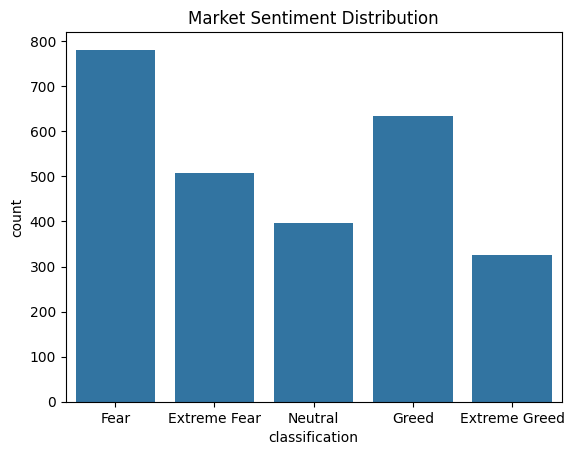

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Sentiment distribution
sns.countplot(data=fg_df, x='classification')
plt.title("Market Sentiment Distribution")
plt.savefig("outputs/sentiment_distribution.png")
plt.show()




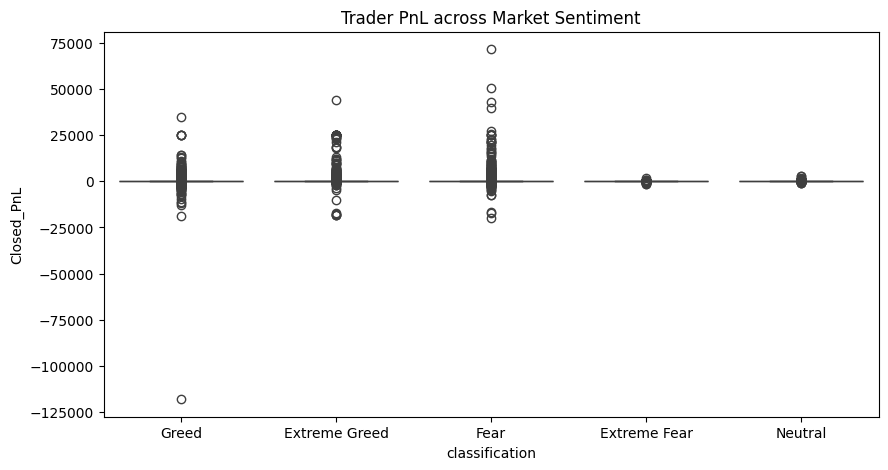

In [ ]:
# 2. PnL across sentiments
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df, x='classification', y='Closed_PnL')
plt.title("Trader PnL across Market Sentiment")
plt.savefig("outputs/pnl_vs_sentiment.png")
plt.show()



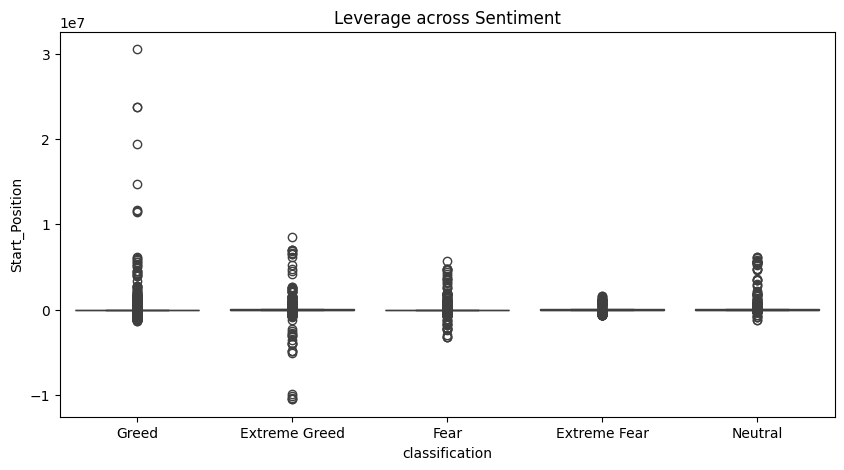

In [ ]:
# 3. Leverage across sentiments
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df, x='classification', y='Start_Position')
plt.title("Leverage across Sentiment")
plt.savefig("outputs/leverage_vs_sentiment.png")
plt.show()



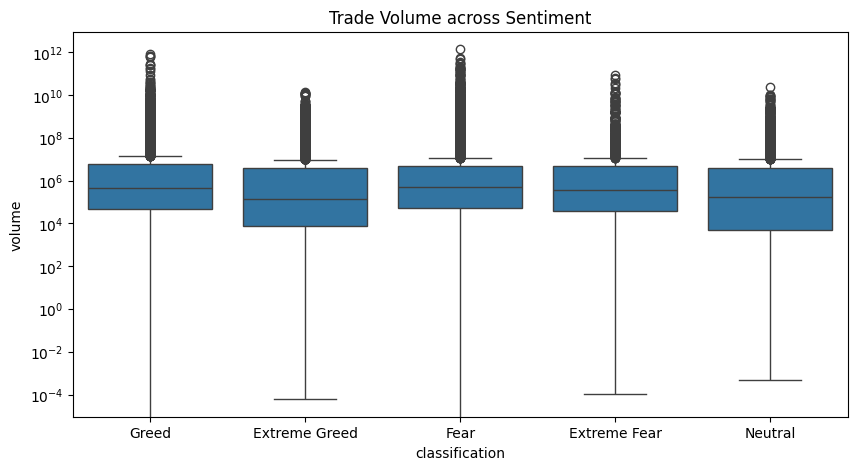

In [ ]:
# 4. Volume comparison
merged_df['volume'] = (merged_df['Execution_Price'] * 
                       merged_df['Size_Tokens'] * 
                       merged_df['Size_USD'])
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df, x='classification', y='volume')
plt.title("Trade Volume across Sentiment")
plt.yscale('log')  # Handle large range
plt.savefig("outputs/volume_vs_sentiment.png")
plt.show()

In [ ]:
agg_stats = merged_df.groupby('classification').agg({
    'Closed_PnL': ['mean', 'median'],
    'Start_Position': ['mean', 'median'],
    'volume': ['mean', 'median']
})

# Flatten multi-index columns
agg_stats.columns = ['_'.join(col) for col in agg_stats.columns]
agg_stats.reset_index(inplace=True)

print("Aggregated Statistics:")
display(agg_stats)

# Save to CSV
agg_stats.to_csv("csv_files/sentiment_aggregated_stats.csv", index=False)


Aggregated Statistics:


,classification,Closed_PnL_mean,Closed_PnL_median,Start_Position_mean,Start_Position_median,volume_mean,volume_median
0,Extreme Fear,1.891632,0.00000,21902.797505,10598.080000,2.634378e+08,358947.827578
1,Extreme Greed,205.816345,0.96048,24593.241160,2155.348602,9.237503e+07,133225.000000
2,Fear,128.287950,0.00000,8146.358518,11.367760,7.470845e+08,495447.223331
3,Greed,53.988003,0.00000,37276.787811,6.633095,5.616599e+08,455733.614899
4,Neutral,27.088803,0.00000,89199.587406,3105.495947,1.606360e+08,169588.122294
